# HW 12: The Big Challenge
## Abigail Kahler, HWRS 582

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = 150 m  

#### Topography
- Bottom of the domain is flat, bottom layer is 40m thick
- Middle layer is also flat, and 5 m thick
- Top layer elevation is provided in BASE_TOP_ELEV_CSV

#### Subsurface Properties: 
- Homogeneous within each of three layers 
- K top and bottom layers = 8.5 m/day in x, y and z.
- K middle layer = same as top and bottom for leftmost 20 columns
- K middle layer: 0.0001 m/day in z direction for rightmost 30 columns 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001   

#### Boundary Conditions: 
 - Right boundary for all layers is defined by a constant head of 70 m relative to the datum (located at bottom of domain).
 - Left, top, and bottom boundaries are no flow.
 
#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 x horizontal K of top layer
- Streambed thickness = 1 m
- Stream bottom depth = 2 m #to set stream 1 m below ground surface
- Stage = .5 m

#### Well: 
 - Town pumping well
     - Located at row 21, column 38 screened in bottom layer
     - Pumping at a rate of 1500 m^3/day 
     - Some treated water returned to stream at column 25

  - Ag pumping well
    - Screen in top layer, row 12, columns 14
    - Pumping rate = crop water demand plus 20% for excess irrigation
      plus 30% for irrigation efficiency
    - Pumping rate wheat = 3000 m/day
    - Pumping rate pistachios = 4500 m/day
    - Pumping rate cotton = 6000 m/day
     

## 1. Setup the environment

In [46]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from matplotlib import ticker

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [47]:
## model directory
moddir= "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

#NEED SURFACE INFORMATION LINE FROM LAURA'S PPT SLIDE


zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_xyz = 8.5   # m/day horizontal hydraulic conductivity in x, y, z 
K_mid_z = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 #m/day

## Well
#pumping = -500 #m3/day  #given
#well_xy= [2500, 2500] #xy location of well 
#well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
#well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
#well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
#print(well_loc)
#print(well_col)


## Boundary conditions
h_right = 70

## 4. Setup and run MODFLOW for three scenarios

#### 4.1 Model Run 1: No Town No Ag (NTNA)

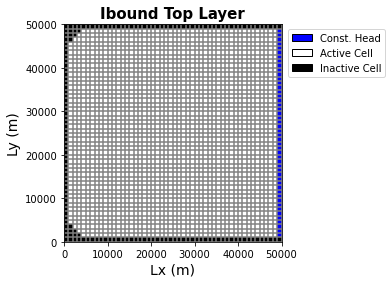

In [48]:
#Initialize the model
modelname1 = "NTNA"    #No Town No Ag = steady state with no pumping from town well
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

## Make some changes to the parameters
#nlay_3lay=3  #two layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45   # bottom elevation of top layer (0) is 45 m 
botm[1,:,:] = 40   # bottom elevation of middle layer (1) is 40 m

## Make arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_xyz                   # assign the original value to the entire array
Kz[1,20:-1,:] = K_mid_z             # assign middle layer Kz in right half of domain

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_xyz                  # assign the original value to the entire array

#Create dis object
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)     #array of ones to make every cell active
ibound[:, :, -1] = -1   #right boundary of constant head
ibound[:,:,0] = 0       #left boundary of no flow
ibound[:,0,:] = 0       #top boundary of no flow
ibound[:,-1,:] = 0      #bottom boundary of no flow

#Impermeable Bedrock
#Loop credited to David Morales, after much individual and collaborative troubleshooting
for i in range(0,9):                     #top layer bedrock
    if i <= 5:
        ibound[0, i, 0:5-i] = 0
        ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:                    #middle layer bedrock
        for j in range(0,7):
            ibound[1, j, 0:7-j] = 0
            ibound[1, -1-j, 0:7-j] = 0
    else:
        for k in range(0,9):             #bottom layer bedrock
            ibound[2, k, 0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#------------------------------------------------------
#Model Map Layer 2
#plot grid and ibound
#plt.figure(figsize = (4,4))
#modelmap = flopy.plot.PlotMapView(model=m1, layer=2)
#grid = modelmap.plot_grid()
#ib = modelmap.plot_ibound()
#add labels and legend
#plt.xlabel('Lx (m)',fontsize = 14)
#plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Ibound Bottom Layer', fontsize = 15, fontweight = 'bold')
#plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
#                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
#                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
#                   bbox_to_anchor=(1.5,1.0))
#plt.show(modelmap)
#-------------------------------------------------------

#Model Map Layer 1
#plot grid and ibound
#plt.figure(figsize = (4,4))
#modelmap = flopy.plot.PlotMapView(model=m1, layer=1)
#grid = modelmap.plot_grid()
#ib = modelmap.plot_ibound()
#add labels and legend
#plt.xlabel('Lx (m)',fontsize = 14)
#plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Ibound Middle Layer', fontsize = 15, fontweight = 'bold')
#plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
#                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
#                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
#                   bbox_to_anchor=(1.5,1.0))
#plt.show(modelmap)
#-------------------------------------------------------

#Model Map Layer 0
#plot grid and ibound
plt.figure(figsize = (4,4))
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound Top Layer', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)
#-------------------------------------------------------

#Well
#well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
#well_1 = [i for i in well_loc] + [pumping]
#print(well_1)
#print("Well 1 [layer, row, column, flux]: \n", well_1)
#wel_spd = {0: [well_1]} #putting the well in the bottom layer
#wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)



In [49]:
#STREAM WITH MULTIPLE SEGMENTS
stage = 0.5 #given: .5 m above bed



#STREAM WITH MULTIPLE REACHES
#Setup the stream characteristics
nseg = 3 # number of segments
ntrib=2 # two tributaries (for return flow & upstream section)
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 

#Calculate the streambed conductance
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 

#STREAM THICKNESS, NOT SURE
thickness = sed_thick + 7  #(str_bott = 7 in single segment example)

#Setup the reach locations, stream segment numbers, and reach numbers
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 25    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)

ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - thickness      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

#5. Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data  
#for r in np.arange(nreach): 
#     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], Kstream, Sbot[r], Stop[r],    		width,  slope, rough]
#str_spd = {0: str_info} # save the stream info in a stress period dictionary

for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r],    		width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary



#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
#rech_zone[:,0:16] = recharge                    #recharge only occurs in 15 leftmost columns
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)     #create rch object

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  9:47:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  9:47:01
 Elapsed run time:  0.067 Seconds

  Normal termination of simulation
